# Scalar Gaussian CFAR Detector
MH, v1.1, 2022_08_08

## Lib

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
from pathlib import Path
from tqdm import tqdm

In [2]:
from numpy import pi, exp, min, max, sum, mean, median, std, sqrt, var
from scipy.stats import poisson, norm, uniform
from scipy.ndimage import convolve
from scipy.special import erf

In [3]:
import matplotlib.patches as patches

In [4]:
from mpl_toolkits import mplot3d

## Init

In [5]:
# %config InlineBackend.figure_format = 'retina'

In [6]:
matplotlib.rc('image', cmap='plasma')
matplotlib.rcParams['figure.figsize'] = (8,8)
matplotlib.rcParams['font.size'] = 12

In [7]:
seed = 0

## Paths

In [8]:
output_directory = Path('c:/Users/miros/home/work/jhi/projects/' + 
    'plasmonic_microscopy/data/super_resolution/analysis/jupyter/scalar_gauss_cfar/')

In [9]:
output_directory.mkdir(exist_ok=True)

## Parameters

### Image

In [10]:
size = 128
shape = (size,size)

### Background

In [11]:
background_mean = 450
background_parabola_curve = 10
(background_parabola_x0, background_parabola_y0) = (0,0)

### Read-Out Noise

In [12]:
noise_std = 10

### Single Spot

In [13]:
sigma = 1
n_photons = 1000
(x0,y0) = (64,64)

### Multiple Spots

In [14]:
n_spots = 30

In [15]:
multispot_sigma_mean = 1
multispot_sigma_std = 0.1

In [16]:
multispot_n_photons_mean = 1000
multispot_n_photons_std = 100

In [17]:
multispot_margin = int(np.ceil(3*sigma))

### Pfa

In [18]:
log_pfa = -6
pfa = 10**log_pfa

### CFAR Window

In [19]:
guard_interval = int(np.ceil(2*sigma))
reference_interval = int(np.ceil(4*sigma))

### Local Max Window

In [20]:
local_max_range = int(np.ceil(2*sigma))

### Dictionaries

In [21]:
background_dict = {
    'mean': background_mean, 
    'center': (background_parabola_x0, background_parabola_y0),
    'a': background_parabola_curve,
    'noise_std': noise_std,    
    'size': size,
    'shape': (size,size),
    'var': background_mean + noise_std**2
}

signal_dict = {
    'sigma': sigma,
    'n_photons': n_photons,
    'center': (x0,y0),    
    'n_spots': n_spots,    
    'multispot_sigma_mean': multispot_sigma_mean,
    'multispot_sigma_std': multispot_sigma_std,
    'multispot_n_photons_mean': multispot_n_photons_mean,
    'multispot_n_photons_std': multispot_n_photons_std,    
    'multispot_margin': multispot_margin,
    'size': size,
}

detector_dict = {    
    'log_pfa': log_pfa,
    'pfa': pfa,
    'guard_interval': guard_interval,
    'reference_interval': reference_interval,    
    'local_max_range': local_max_range,
    'size': size, 
}

## Theoretical Performance

### Parameters

In [22]:
M = 10**5

In [23]:
lambda_b = 450
lambda_s = 159 # corresponds to 1000 photons, i.e. 1000/(2pi)=159

In [24]:
sigma_n = 10

In [25]:
sigma_b = sqrt( lambda_b + sigma_n**2 )

In [26]:
log_pfa_simul = -4
pfa_simul = 10**log_pfa_simul

### Received Signal

In [27]:
r0 = norm.rvs(loc=lambda_b, scale=sigma_b, size=M, random_state=seed)

In [28]:
r1 = norm.rvs(loc=(lambda_s+lambda_b), scale=sqrt(lambda_s + sigma_b**2), 
    size=M, random_state=seed)

### Show Histogram

In [29]:
from ipynb.fs.defs.scalar_poisson_cfar_detector import show_histogram

### T0 Distribution

In [30]:
t0 = r0

In [31]:
(output_directory/'statistics').mkdir(exist_ok=True)

In [32]:
var(t0)

547.0775491035907

In [33]:
lambda_b + sigma_n**2

550

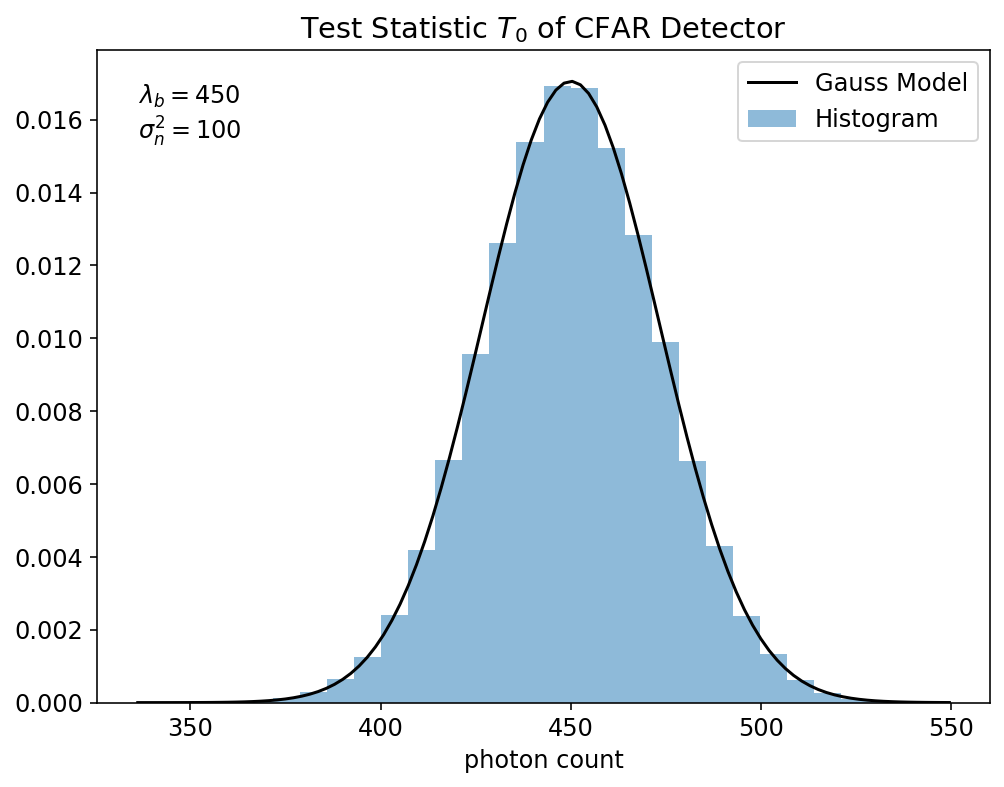

In [34]:
show_histogram(t0, 
    title=r'Test Statistic $T_0$ of CFAR Detector', 
    text=r'$\lambda_b={}$'.format(lambda_b) + '\n' +
        r'$\sigma_n^2={}$'.format(sigma_n**2),
    gauss_fit=True, show_legend=True, xlabel='photon count',
    output_file_path=output_directory/'statistics'/'t0_hist.png')

### T1 Distribution

In [35]:
t1 = r1

In [36]:
mean(t1)

609.041982889432

In [37]:
var(t1)

705.232695117174

In [38]:
lambda_s + sigma_b**2

709.0000000000001

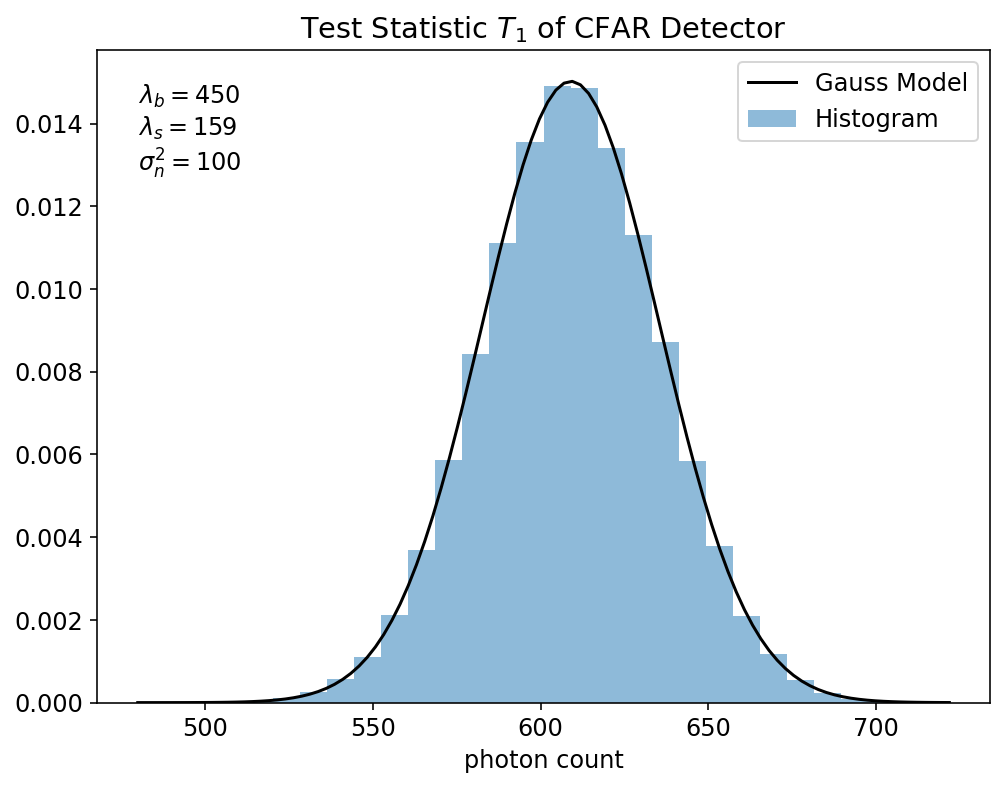

In [39]:
show_histogram(t1, 
    title=r'Test Statistic $T_1$ of CFAR Detector',                    
    text=r'$\lambda_b={}$'.format(lambda_b) +'\n'+
        r'$\lambda_s={}$'.format(lambda_s) +'\n' +
        r'$\sigma_n^2={}$'.format(sigma_n**2),
    gauss_fit=True, show_legend=True, xlabel='photon count',
    output_file_path=output_directory/'statistics'/'t1_hist.png')

### T0, T1 Distributions

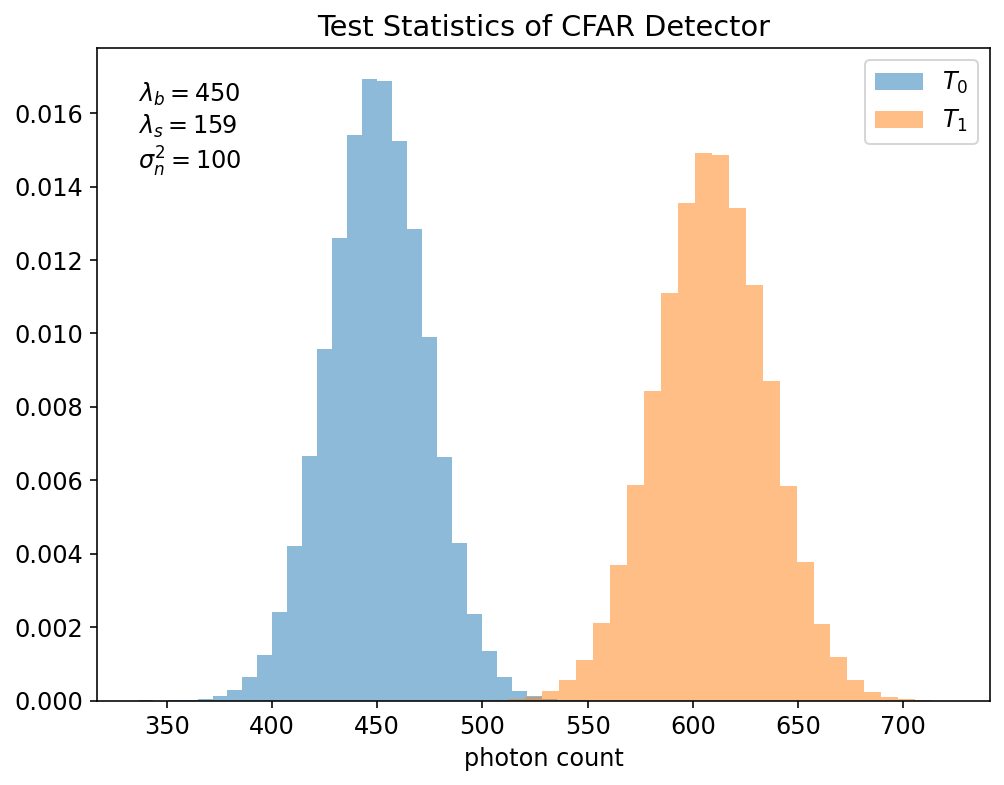

In [40]:
fig, ax = plt.subplots(figsize=(8,6))

plt.hist(t0, bins=30, alpha=0.5, density=True, label=r'$T_0$')        
plt.hist(t1, bins=30, alpha=0.5, density=True, label=r'$T_1$')        

plt.title(r'Test Statistics of CFAR Detector')        

_, ymax = plt.ylim()

plt.text(min(t0), 0.95*ymax, 
    r'$\lambda_b={}$'.format(lambda_b) +'\n'+
    r'$\lambda_s={}$'.format(lambda_s) +'\n' +
    r'$\sigma_n^2={}$'.format(sigma_n**2), va='top')
        
plt.xlabel('photon count')
plt.legend()
plt.savefig(output_directory/'statistics'/'t0t1_hist.png',
    dpi=300, facecolor='w', bbox_inches='tight')
plt.show() 

### Threshold

In [41]:
tau = norm.isf(pfa_simul, loc=lambda_b, scale=sqrt(lambda_b+sigma_n**2))

In [42]:
tau

537.2186676721224

### Pfa

In [43]:
sum(t0>tau)/len(t0)

9e-05

In [44]:
pfa_simul

0.0001

### Pd

In [45]:
pd = norm.sf(tau, loc=(lambda_s+lambda_b), scale=sqrt(lambda_s+lambda_b+sigma_n**2) )
pd

0.9964890569502916

In [46]:
sum(t1>tau)/len(t1)

0.99627

### ROC

In [47]:
(output_directory/'roc').mkdir(exist_ok=True)

In [48]:
pfa_n = np.linspace(0, 10**-6, 1000)

In [49]:
def pd_pfa(lambda_s, lambda_b, sigma_n, pfa_n):
    return [norm.sf( norm.isf(p, loc=lambda_b, scale=sqrt(lambda_b+sigma_n**2)), 
        loc=(lambda_s+lambda_b), scale=sqrt(lambda_s+lambda_b+sigma_n**2) ) for p in pfa_n]

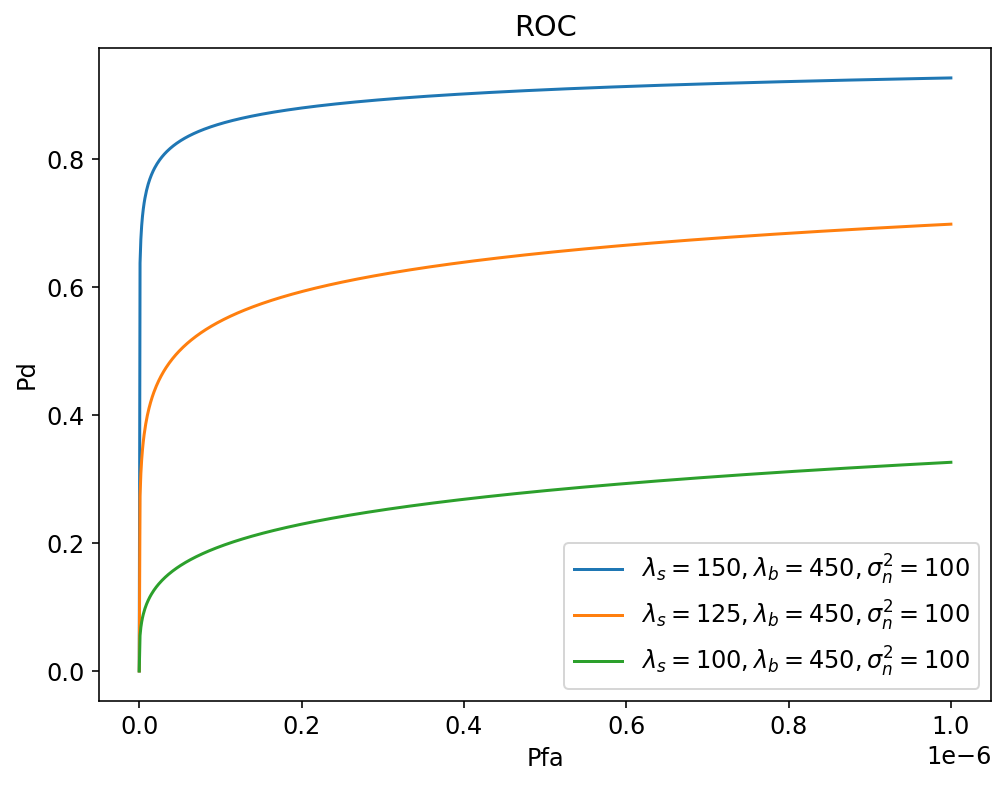

In [50]:
plt.figure(figsize=(8,6))
plt.plot(pfa_n, pd_pfa(150, lambda_b, sigma_n, pfa_n), 
    label=r'$\lambda_s=150, \lambda_b={}, \sigma_n^2={}$'.format(lambda_b, sigma_n**2))
plt.plot(pfa_n, pd_pfa(125, lambda_b, sigma_n, pfa_n), 
    label=r'$\lambda_s=125, \lambda_b={}, \sigma_n^2={}$'.format(lambda_b, sigma_n**2))
plt.plot(pfa_n, pd_pfa(100, lambda_b, sigma_n, pfa_n), 
    label=r'$\lambda_s=100, \lambda_b={}, \sigma_n^2={}$'.format(lambda_b, sigma_n**2))

plt.title('ROC')
plt.xlabel('Pfa')
plt.ylabel('Pd')
plt.legend()
plt.savefig(output_directory/'roc'/'roc.png',
            dpi=300, facecolor='w', bbox_inches='tight')
plt.show()

## Real Performance

### Signal Generation

In [51]:
from ipynb.fs.defs.scalar_poisson_cfar_detector import poisson_noise
from ipynb.fs.defs.scalar_poisson_cfar_detector import awgn_noise

In [52]:
from ipynb.fs.defs.scalar_poisson_cfar_detector import get_uniform_background
from ipynb.fs.defs.scalar_poisson_cfar_detector import get_uniform_background_poisson
from ipynb.fs.defs.scalar_poisson_cfar_detector import get_uniform_background_poisson_awgn

from ipynb.fs.defs.scalar_poisson_cfar_detector import get_nonuniform_background
from ipynb.fs.defs.scalar_poisson_cfar_detector import get_nonuniform_background_poisson

In [53]:
from ipynb.fs.defs.scalar_poisson_cfar_detector import parabola2d
from ipynb.fs.defs.scalar_poisson_cfar_detector import parabola_signal
from ipynb.fs.defs.scalar_poisson_cfar_detector import set_array_mean

In [54]:
from ipynb.fs.defs.scalar_poisson_cfar_detector import random_coordinates
from ipynb.fs.defs.scalar_poisson_cfar_detector import multiple_gauss_signals

In [55]:
from ipynb.fs.defs.scalar_poisson_cfar_detector import get_multi_spot
from ipynb.fs.defs.scalar_poisson_cfar_detector import get_multi_spot_uniform_background_poisson
from ipynb.fs.defs.scalar_poisson_cfar_detector import get_multi_spot_nonuniform_background_poisson

In [56]:
from ipynb.fs.defs.scalar_poisson_cfar_detector import show_image

#### Background

##### Uniform

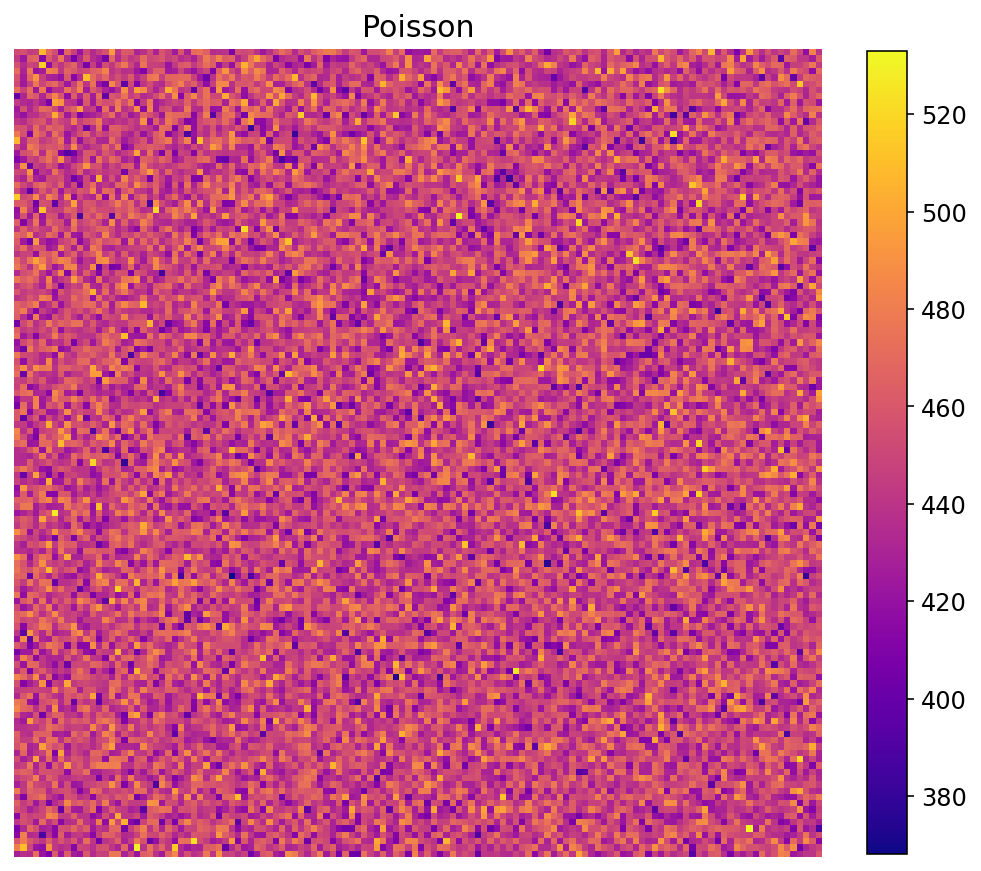

In [57]:
uniform_background_poisson = get_uniform_background_poisson(
    background_dict, seed=seed)

show_image(uniform_background_poisson, title='Poisson')

In [58]:
mean(uniform_background_poisson), var(uniform_background_poisson)

(449.7021484375, 455.9564504623413)

In [59]:
uniform_background_poisson_awgn = get_uniform_background_poisson_awgn(
    background_dict, seed=seed)

show_image(uniform_background_poisson_awgn, 'AWGN')

In [60]:
mean(uniform_background_poisson_awgn), var(uniform_background_poisson_awgn)

(449.6446402821905, 553.3922966836976)

##### Non-Uniform

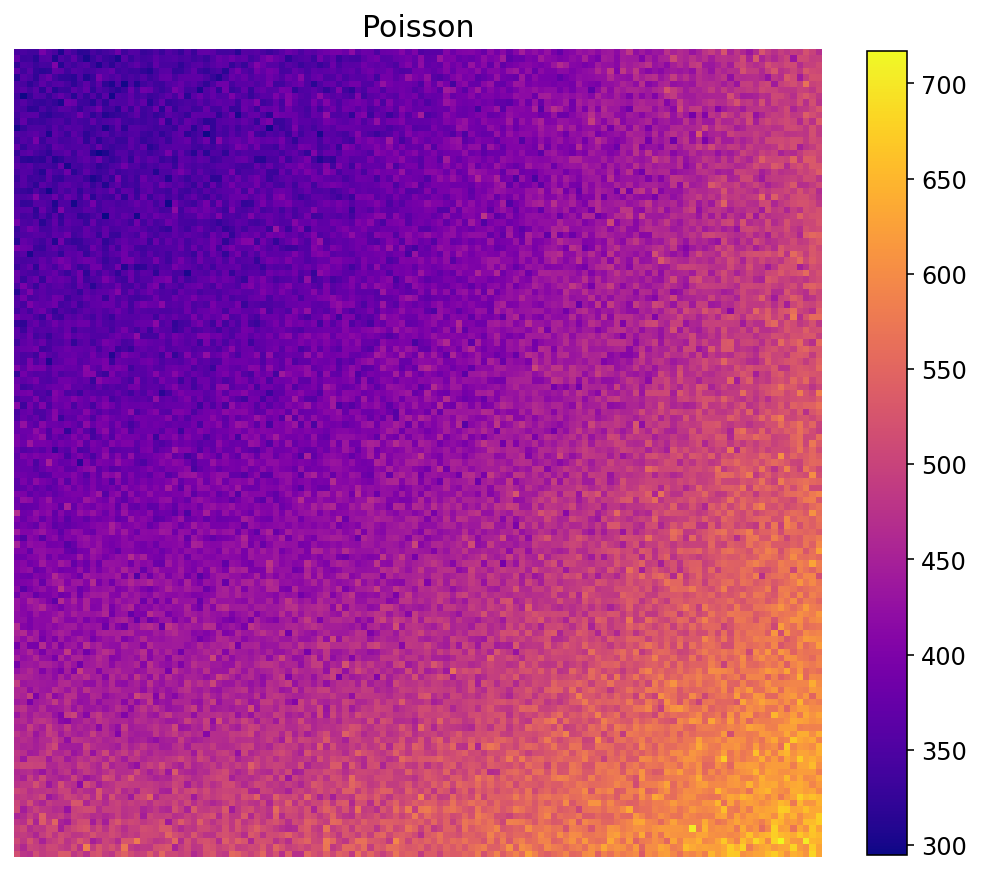

In [61]:
nonuniform_background_poisson = get_nonuniform_background_poisson(
    background_dict, seed=seed)

show_image(nonuniform_background_poisson, title='Poisson')

In [62]:
def get_nonuniform_background_poisson_awgn(background_dict, seed=seed):    

    nonuniform_background_poisson = get_nonuniform_background_poisson(
        background_dict, seed=seed)
    
    awgn = awgn_noise(background_dict['noise_std'], background_dict['shape'], seed=seed) 
    
    return nonuniform_background_poisson + awgn

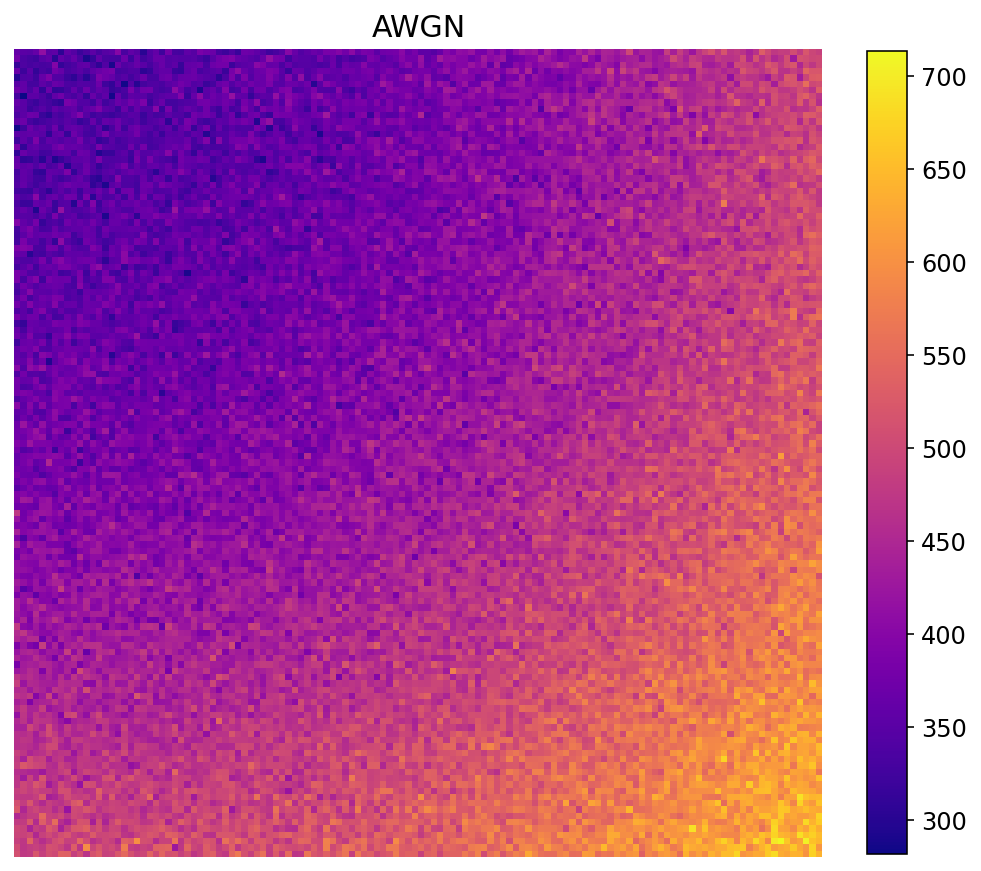

In [63]:
nonuniform_background_poisson_awgn = get_nonuniform_background_poisson_awgn(
    background_dict, seed=seed)

show_image(nonuniform_background_poisson_awgn, title='AWGN')

#### Multiple Spots

In [64]:
from ipynb.fs.defs.scalar_poisson_cfar_detector import integrated_gauss2d

In [65]:
multi_spot_uniform_background_poisson = get_multi_spot_uniform_background_poisson(
    signal_dict, integrated_gauss2d, background_dict, seed=seed)

show_image(multi_spot_uniform_background_poisson, title='Poisson')

In [66]:
def get_multi_spot_uniform_background_poisson_awgn(
    signal_dict, integrated_gauss2d, background_dict, seed=seed):    

    multi_spot_uniform_background_poisson = get_multi_spot_uniform_background_poisson(
        signal_dict, integrated_gauss2d, background_dict, seed=seed)
    
    awgn = awgn_noise(background_dict['noise_std'], background_dict['shape'], seed=seed) 
    
    return multi_spot_uniform_background_poisson + awgn

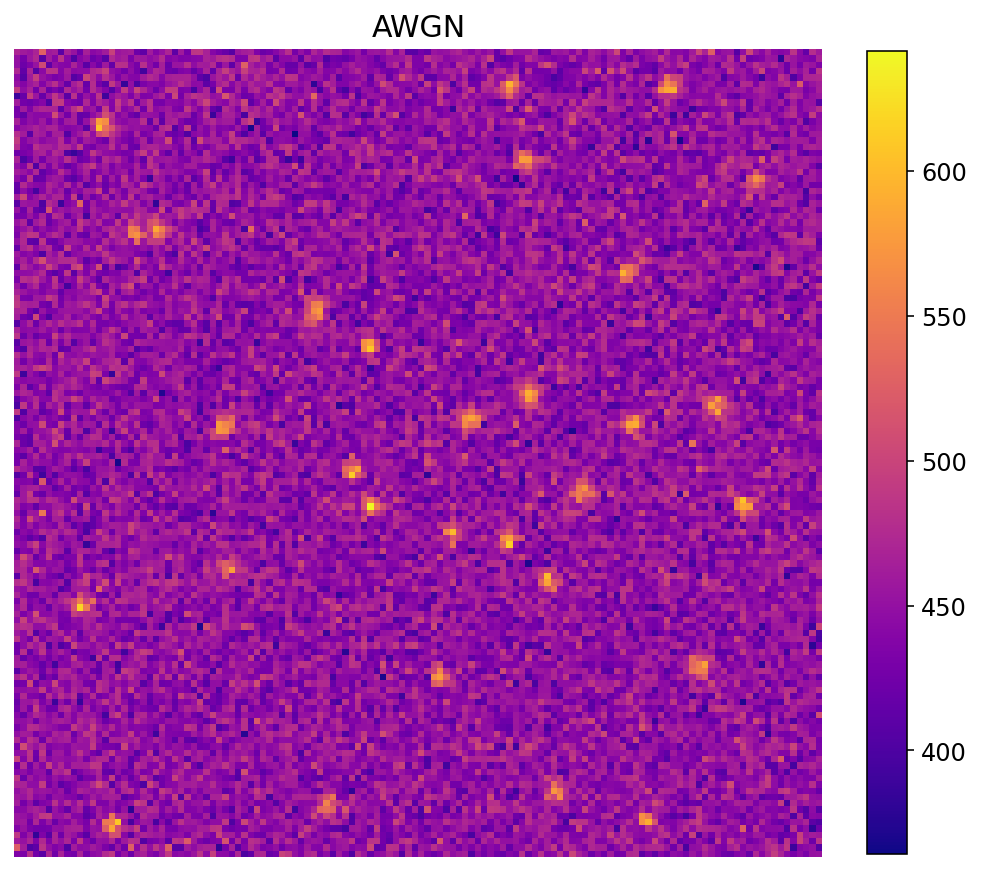

In [67]:
multi_spot_uniform_background_poisson_awgn = get_multi_spot_uniform_background_poisson_awgn(
    signal_dict, integrated_gauss2d, background_dict, seed=seed)

show_image(multi_spot_uniform_background_poisson_awgn, title='AWGN')

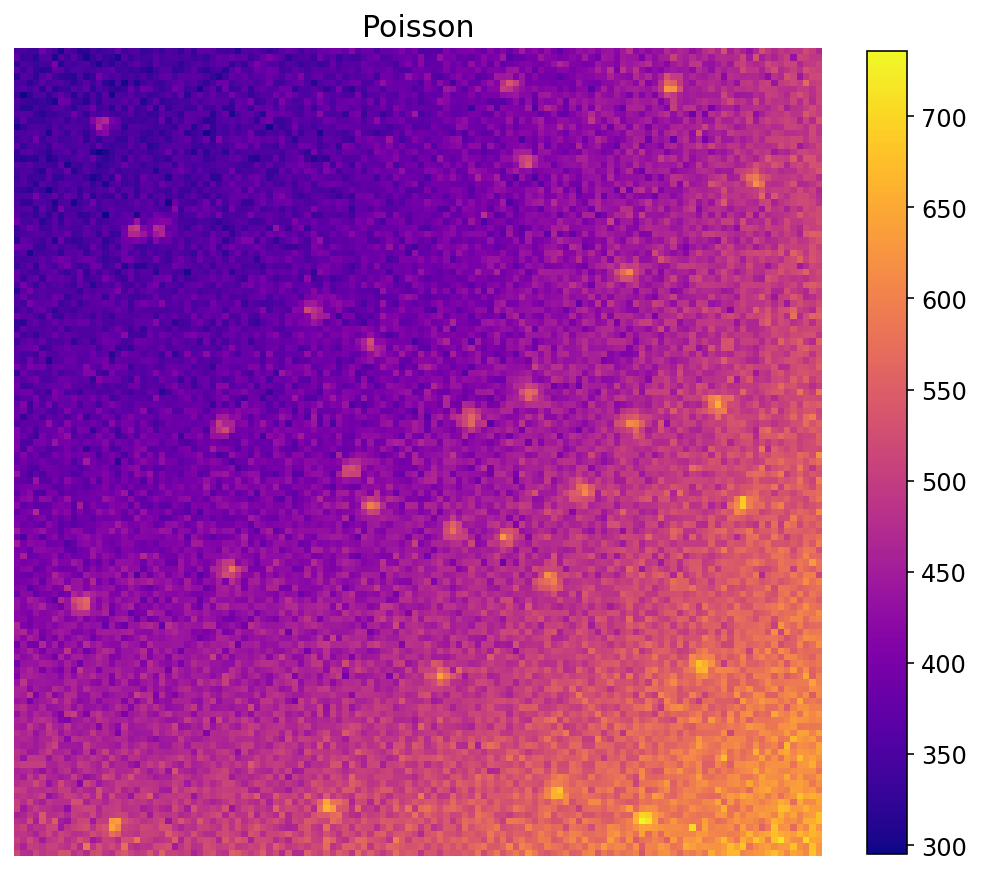

In [68]:
multi_spot_nonuniform_background_poisson = get_multi_spot_nonuniform_background_poisson(
    signal_dict, integrated_gauss2d, background_dict, seed=seed)

show_image(multi_spot_nonuniform_background_poisson, title='Poisson')

In [69]:
def get_multi_spot_nonuniform_background_poisson_awgn(
    signal_dict, integrated_gauss2d, background_dict, seed=seed):    

    multi_spot_nonuniform_background_poisson = get_multi_spot_nonuniform_background_poisson(
        signal_dict, integrated_gauss2d, background_dict, seed=seed)

    awgn = awgn_noise(background_dict['noise_std'], background_dict['shape'], seed=seed) 
    
    return multi_spot_nonuniform_background_poisson + awgn

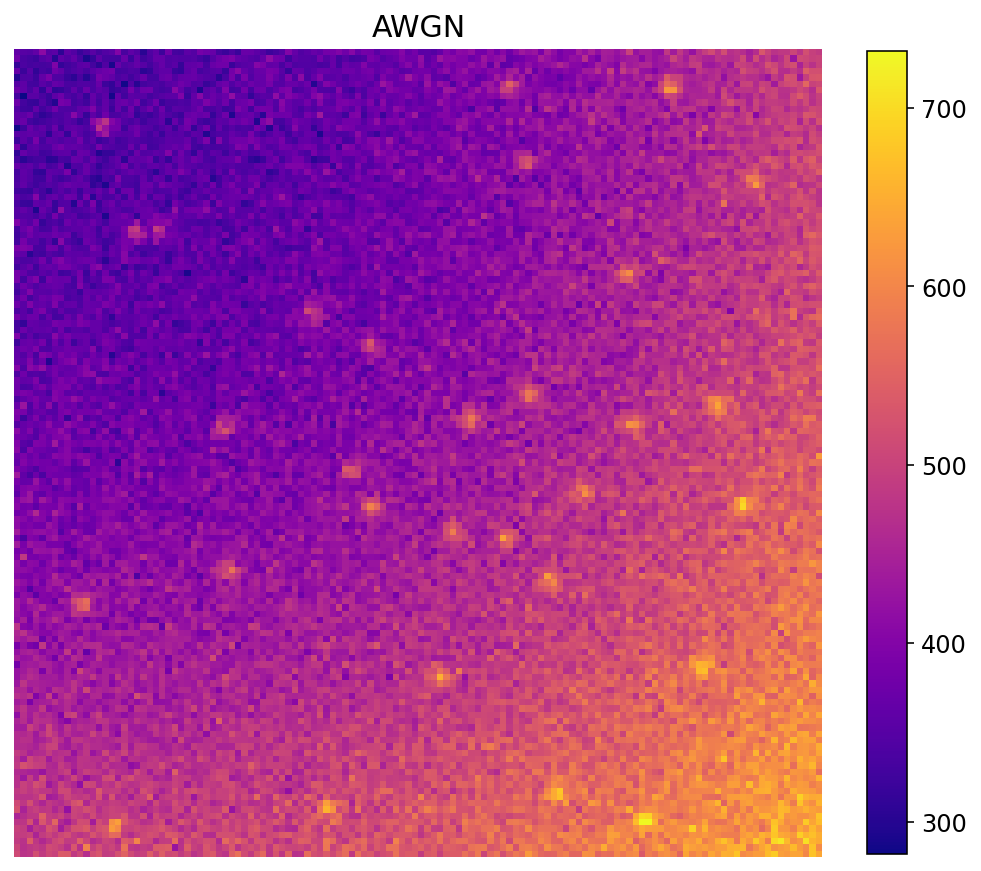

In [70]:
multi_spot_nonuniform_background_poisson_awgn = get_multi_spot_nonuniform_background_poisson_awgn(
    signal_dict, integrated_gauss2d, background_dict, seed=seed)

show_image(multi_spot_nonuniform_background_poisson_awgn, title='AWGN')

### Test Statistics

In [71]:
T0_uniform = uniform_background_poisson_awgn
T0_nonuniform = nonuniform_background_poisson_awgn
T1_uniform = multi_spot_uniform_background_poisson_awgn
T1_nonuniform = multi_spot_nonuniform_background_poisson_awgn

### CFAR

#### Mean Estimate

In [72]:
def cfar_background_mean_estimate(T): return median(T)

In [73]:
cfar_background_mean_estimate(uniform_background_poisson_awgn)

449.6783866586328

In [74]:
cfar_background_mean_estimate(multi_spot_uniform_background_poisson_awgn)

450.6031508988621

In [75]:
cfar_background_mean_estimate(multi_spot_nonuniform_background_poisson_awgn)

446.25388088610646

#### Variance Estimate

In [76]:
from scipy.stats import median_abs_deviation

In [77]:
from scipy.stats import iqr

In [78]:
from statsmodels.robust.scale import qn_scale

In [79]:
# def cfar_background_std_estimate(T): return median_abs_deviation(T.ravel(), scale='normal')

def cfar_background_std_estimate(T): return iqr(T.ravel(), scale='normal')

# def cfar_background_std_estimate(T): return qn_scale(T.ravel())

In [80]:
cfar_background_std_estimate(uniform_background_poisson_awgn)**2

550.1368011303363

In [81]:
cfar_background_std_estimate(multi_spot_uniform_background_poisson_awgn)**2

576.2847555830591

In [82]:
cfar_background_std_estimate(multi_spot_nonuniform_background_poisson_awgn)**2

6384.644520528439

#### Threshold

In [83]:
def isf_threshold(pfa, background_mean, background_std):
    
    threshold = norm.isf(pfa, loc=background_mean, scale=background_std)
    
    return threshold

In [84]:
isf_threshold(pfa, background_dict['mean'], sqrt(background_dict['var']))

561.4776814561536

In [85]:
isf_threshold(pfa,
    cfar_background_mean_estimate(uniform_background_poisson_awgn), 
    cfar_background_std_estimate(uniform_background_poisson_awgn)    
)

561.1699311371963

In [86]:
isf_threshold(pfa,
    cfar_background_mean_estimate(multi_spot_uniform_background_poisson_awgn), 
    cfar_background_std_estimate(multi_spot_uniform_background_poisson_awgn)    
)

564.7135300785795

In [87]:
isf_threshold(pfa,
    cfar_background_mean_estimate(multi_spot_nonuniform_background_poisson_awgn), 
    cfar_background_std_estimate(multi_spot_nonuniform_background_poisson_awgn)    
)

826.0713571933636

#### CFAR Non-Local Max

In [88]:
def cfar_nonlocal_max(T, pfa):    
    
    background_mean_estimate = cfar_background_mean_estimate(T)        
    background_std_estimate = cfar_background_std_estimate(T)
    
    threshold = isf_threshold(pfa, background_mean_estimate, background_std_estimate)
    mask = T > threshold
    return mask

In [89]:
(output_directory/'cfar').mkdir(exist_ok=True)
(output_directory/'cfar'/'mask').mkdir(exist_ok=True)

In [90]:
show_image( cfar_nonlocal_max(T1_uniform, pfa),
    title=f'CFAR Nonlocal-Max Mask, Multiple Spots, Uniform Background',
    text=r'$P_{{FA}} = 10^{{{0}}}$'.format(log_pfa),
    output_file_path=output_directory/'cfar'/'mask'/
        'cfar_nonlocalmax_mask_multi_spot_uniform_background_poisson.png',
    show_colorbar=False
 )

#### CFAR

In [91]:
from ipynb.fs.defs.scalar_poisson_cfar_detector import mask2points
from ipynb.fs.defs.scalar_poisson_cfar_detector import neigborhood
from ipynb.fs.defs.scalar_poisson_cfar_detector import is_local_max
from ipynb.fs.defs.scalar_poisson_cfar_detector import local_max_points
from ipynb.fs.defs.scalar_poisson_cfar_detector import points2mask
from ipynb.fs.defs.scalar_poisson_cfar_detector import remove_nonlocal_maxima

In [92]:
def cfar(T, pfa, local_max_range):    
    mask_nonlocal_max = cfar_nonlocal_max(T, pfa)    
    mask = remove_nonlocal_maxima(mask_nonlocal_max, T, local_max_range)    
    return mask

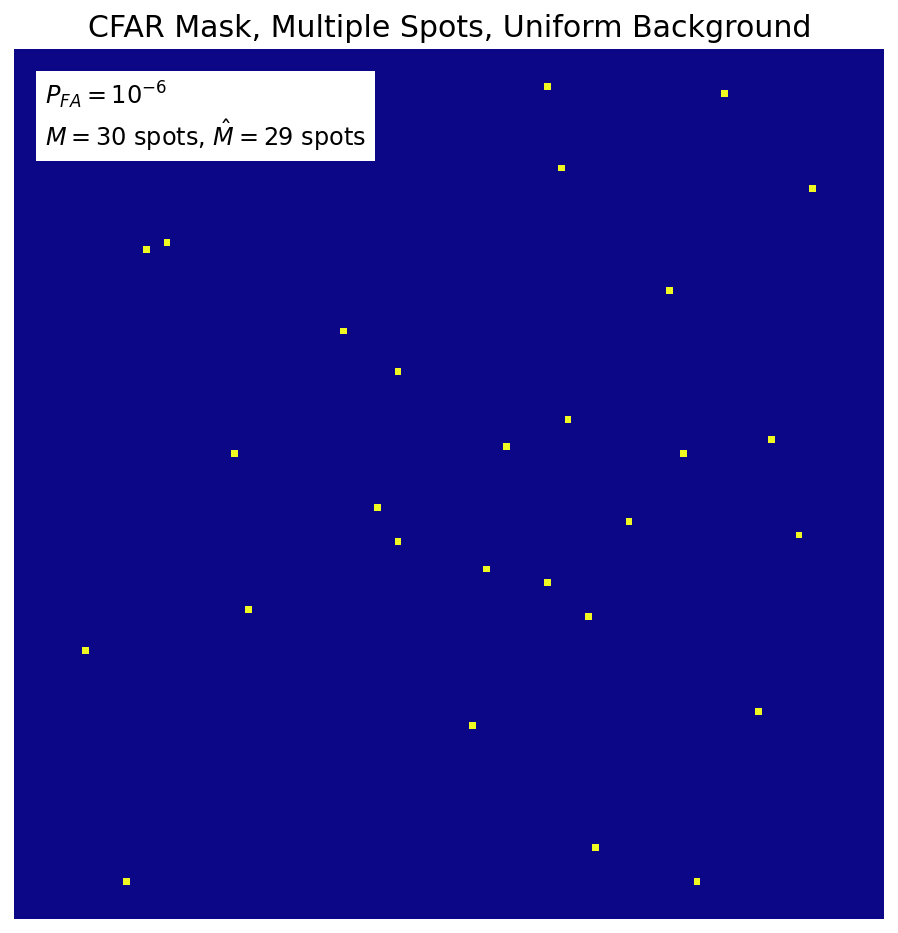

In [93]:
mask = cfar(T1_uniform, pfa, local_max_range)

show_image(mask,
    title='CFAR Mask, Multiple Spots, Uniform Background',
    text=r'$P_{{FA}} = 10^{{{}}}$'.format(log_pfa) +'\n'+
        r'$M={}$ spots'.format(n_spots) + 
            r', $\hat{{M}} = {}$ spots'.format(int(sum(mask))),          
    output_file_path=output_directory/'cfar'/'mask'/
        f'cfar_mask_multi_spot_uniform_background_poisson.png',
    show_colorbar=False
)

#### Detection Test

In [94]:
def detection_test(
    T, detector_type, log_pfa, 
    background_dict, signal_dict, local_max_range, 
    detector_args=None, seed=0,
    title=None, output_file_path=None, close_fig=False):
    
    pfa = 10**log_pfa
    
    if(detector_args is None):
        mask = detector_type(T, pfa, local_max_range)
    else:           
        mask = detector_type( *( (T, pfa, local_max_range) + detector_args ) )
        
    points = mask2points(mask)

    tau = round(isf_threshold(pfa, background_dict['mean'], sqrt(background_dict['var'])))
    
    show_image(T, 
        title=title, 
        text=r'$P_{{FA}} = 10^{{{}}}$ ($\tau={})$'.format(log_pfa, tau) +'\n'+
            r'$M={}$ spots'.format(signal_dict['n_spots']) + 
                r', $\hat{{M}} = {}$ spots'.format(int(sum(mask))) +'\n'+         
            r'seed = {}'.format(seed),               
        points=points, show_colorbar=True,
        output_file_path=output_file_path,
        close_fig=close_fig
    )


In [95]:
(output_directory/'cfar'/'detection').mkdir(exist_ok=True)

In [96]:
detection_test(
    T1_uniform, cfar, log_pfa, 
    background_dict, signal_dict, local_max_range,
    title='CFAR Detections, Multiple Spots, Uniform Background', seed=0)

In [97]:
for i_log_pfa in tqdm([-5,-6]):
    for i_seed in range(3):
        detection_test(
            get_multi_spot_uniform_background_poisson(
                signal_dict, integrated_gauss2d, background_dict, seed=i_seed), 
            cfar, i_log_pfa,
            background_dict, signal_dict, local_max_range,
            title = 'CFAR Detections, Multiple Spots, Uniform Background',
            output_file_path = output_directory/'cfar'/'detection'/
                f'cfar_multi_spot_uniform_background_poisson_logpfa{i_log_pfa}_seed{i_seed}.png',
            seed=i_seed, close_fig=True)

100%|██████████| 2/2 [00:22<00:00, 11.28s/it]


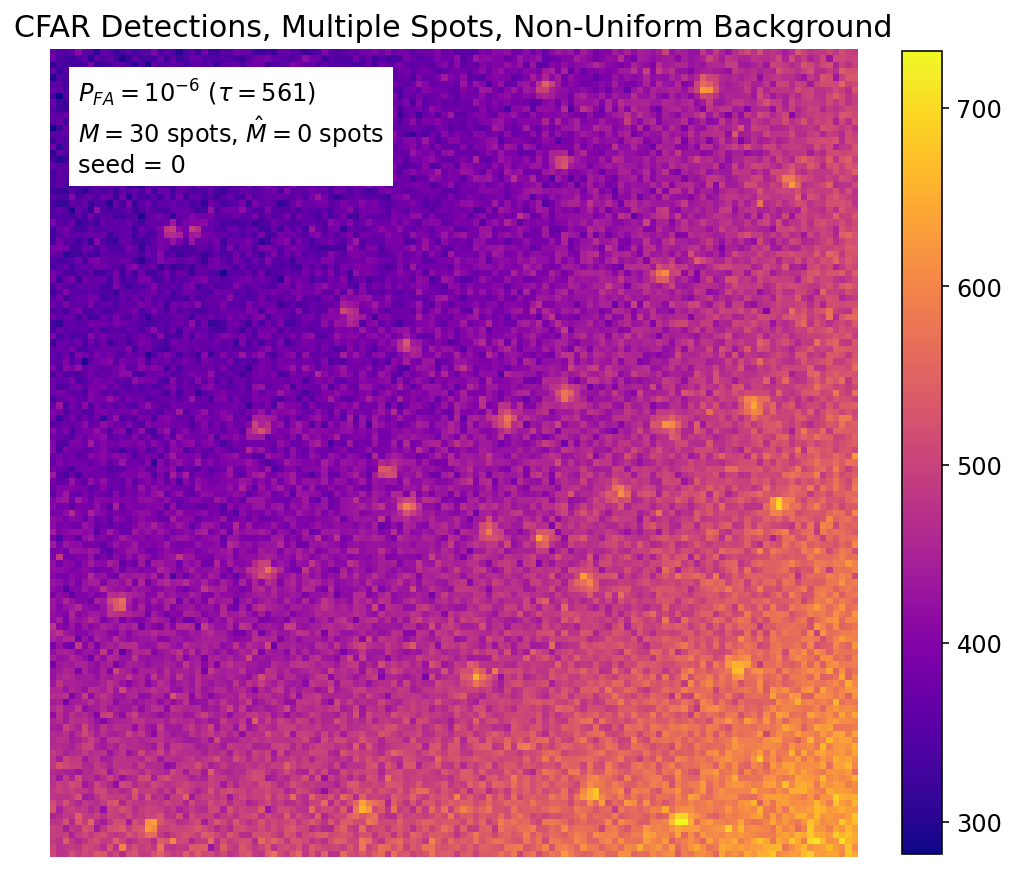

In [98]:
detection_test(    
    T1_nonuniform, cfar, log_pfa, 
    background_dict, signal_dict, local_max_range,
    title='CFAR Detections, Multiple Spots, Non-Uniform Background',
    output_file_path=output_directory/'cfar'/'detection'/
        'cfar_multi_spot_nonuniform_background_poisson.png',)

#### False Alarm Test

In [99]:
def false_alarm_test(
    T, detector_type, log_pfa,
    background_dict, local_max_range,    
    detector_args=None, seed=0,
    title=None, output_file_path=None, close_fig=False):
    
    pfa = 10**log_pfa

    if(detector_args is None):
        mask = detector_type(T, pfa, local_max_range)
    else:           
        mask = detector_type( *( (T, pfa, local_max_range) + detector_args ) )    
    
    points = mask2points(mask)

    tau = round(isf_threshold(pfa, background_dict['mean'], sqrt(background_dict['var'])))
        
    show_image(T, 
        title=title, 
        text=r'$P_{{FA}} = 10^{{{}}}$ ($\tau={}$)'.format(log_pfa, tau) +'\n'+
            r'$\hat{{P}}_{{FA}}= {:0.5f}$'.format(
                len(points)/mask.size) +'\n'+                                  
            r'seed = {}'.format(seed),
        points=points, show_colorbar=True,
        output_file_path=output_file_path,
        close_fig=close_fig
    )

In [100]:
(output_directory/'cfar'/'false_alarm').mkdir(exist_ok=True)

In [101]:
false_alarm_test(
    T0_uniform, cfar, -4,
    background_dict, local_max_range,
    seed=0, 
    title='CFAR Detections, Uniform Background')

In [102]:
for i_log_pfa in tqdm([-3,-4]):
    for i_seed in range(3):
        false_alarm_test(
            get_uniform_background_poisson(background_dict, seed=i_seed), 
            cfar, i_log_pfa,
            background_dict, local_max_range,    
            seed=i_seed,            
            title='CFAR Detections, Uniform Background',                 
            output_file_path = output_directory/'cfar'/'false_alarm'/
                f'cfar_uniform_background_poisson_logpfa{i_log_pfa}_seed{i_seed}.png',
            close_fig=True
        )

100%|██████████| 2/2 [00:03<00:00,  1.68s/it]


##### Export

In [103]:
log_pfa2 = -3
pfa2 = 10**log_pfa2

mask2 = cfar(uniform_background_poisson_awgn, pfa2, local_max_range)  
points2 = mask2points(mask2)

pfa_estimate2 = len(points2)/mask2.size

show_image(uniform_background_poisson_awgn, 
    title='Gaussian CFAR Detector', text_size=18, title_size=24,
    text=r'$P_{{FA}} = 10^{{{}}}$'.format(log_pfa2) +'\n'+
        r'$\hat{{P}}_{{FA}}= {:0.5f}$'.format(pfa_estimate2),
    show_colorbar=False,
    points=points2,
    output_file_path = output_directory/'cfar'/'false_alarm'/
        f'gauss_cfar_uniform_background_poisson_awgn_final.png'           
)

### CA-CFAR

#### Kernel

In [104]:
from skimage.morphology import square, disk

In [105]:
from ipynb.fs.defs.scalar_poisson_cfar_detector import square_annulus_kernel

In [106]:
(output_directory/'cacfar').mkdir(exist_ok=True)
(output_directory/'cacfar'/'kernel').mkdir(exist_ok=True)

In [110]:
square_kernel = square_annulus_kernel(guard_interval, reference_interval)

In [111]:
detector_dict['square_kernel_size'] = sum(square_kernel>0)

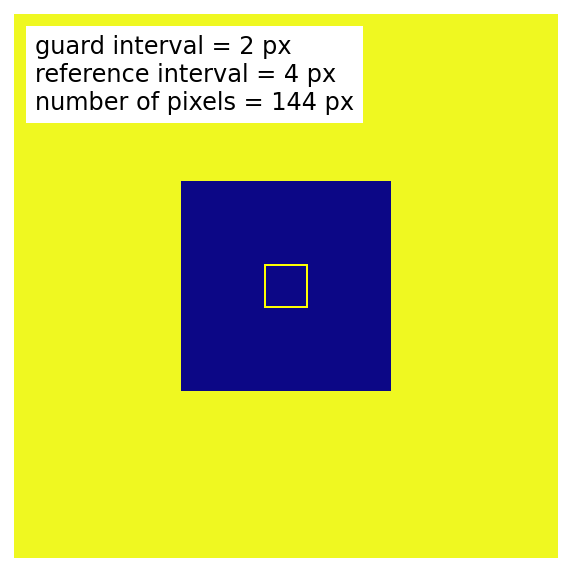

In [112]:
show_image( square_kernel,
    text=r'guard interval = {} px'.format(guard_interval) +'\n'+                                     
        r'reference interval = {} px'.format(reference_interval) +'\n'+       
        r'number of pixels = {} px'.format(detector_dict['square_kernel_size']),    
    text_x=0, text_y=0, 
    figsize=(5,5),
    detection_size=1,       
    points=[(guard_interval+reference_interval,guard_interval+reference_interval)],                  
    output_file_path=output_directory/'cacfar'/'kernel'/'square_annulus.png',
    show_colorbar=False
)

#### Mean Estimate

In [113]:
from ipynb.fs.defs.scalar_poisson_cfar_detector import cacfar_background_mean_estimate

In [114]:
(output_directory/'cacfar'/'background').mkdir(exist_ok=True)

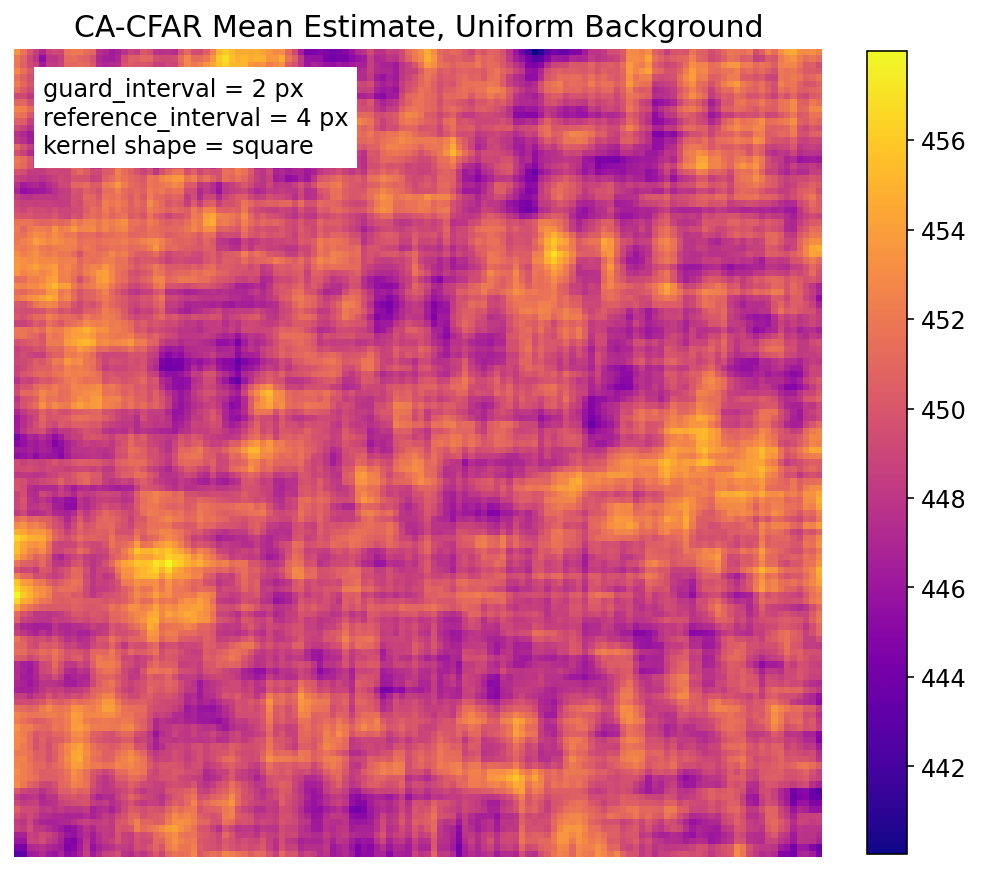

In [115]:
show_image(
    cacfar_background_mean_estimate(
        T0_uniform, square_annulus_kernel, guard_interval, reference_interval),
    title=f'CA-CFAR Mean Estimate, Uniform Background',
    text=r'guard_interval = {} px'.format(guard_interval) +'\n'+                                     
        r'reference_interval = {} px'.format(reference_interval) +'\n'+ 
        r'kernel shape = square',
    output_file_path=output_directory/'cacfar'/'background'/
        'cacfar_uniform_background_square.png',
    )

In [116]:
show_image(cacfar_background_mean_estimate(
    T1_uniform, square_annulus_kernel, guard_interval, reference_interval),
    title=f'CA-CFAR Mean Estimate, Multiple Spots, Uniform Background',
    text=r'guard_interval = {} px'.format(guard_interval) +'\n'+                                     
        r'reference_interval = {} px'.format(reference_interval) +'\n'+ 
        r'kernel shape = square',
    output_file_path=output_directory/'cacfar'/'background'/
        'cacfar_multi_spot_uniform_background_square.png',
    )

In [117]:
show_image(
    cacfar_background_mean_estimate(
        T0_nonuniform, square_annulus_kernel, guard_interval, reference_interval),
    title=f'CA-CFAR Mean Estimate, Non-Uniform Background',
    text=r'guard_interval = {} px'.format(guard_interval) +'\n'+                                     
        r'reference_interval = {} px'.format(reference_interval) +'\n'+ 
        r'kernel shape = square',
    output_file_path=output_directory/'cacfar'/'background'/
        'cacfar_nonuniform_background_square.png',
    )

In [118]:
show_image(
    cacfar_background_mean_estimate(
        T1_nonuniform, square_annulus_kernel, guard_interval, reference_interval),
    title=f'CA-CFAR Mean Estimate, Multiple Spots, Non-Uniform Background',
    text=r'guard_interval = {} px'.format(guard_interval) +'\n'+                                     
        r'reference_interval = {} px'.format(reference_interval) +'\n'+ 
        r'kernel shape = square',
    output_file_path=output_directory/'cacfar'/'background'/
        'cacfar_multi_spot_nonuniform_background_square.png',
    )

#### Variance Estimate

In [119]:
def cacfar_background_std_estimate(
    T, background_mean, kernel_shape, guard_interval, reference_interval):           
    
    background_var_estimate = cacfar_background_mean_estimate(
        (T - background_mean)**2, square_annulus_kernel, guard_interval, reference_interval)

    return sqrt(background_var_estimate)

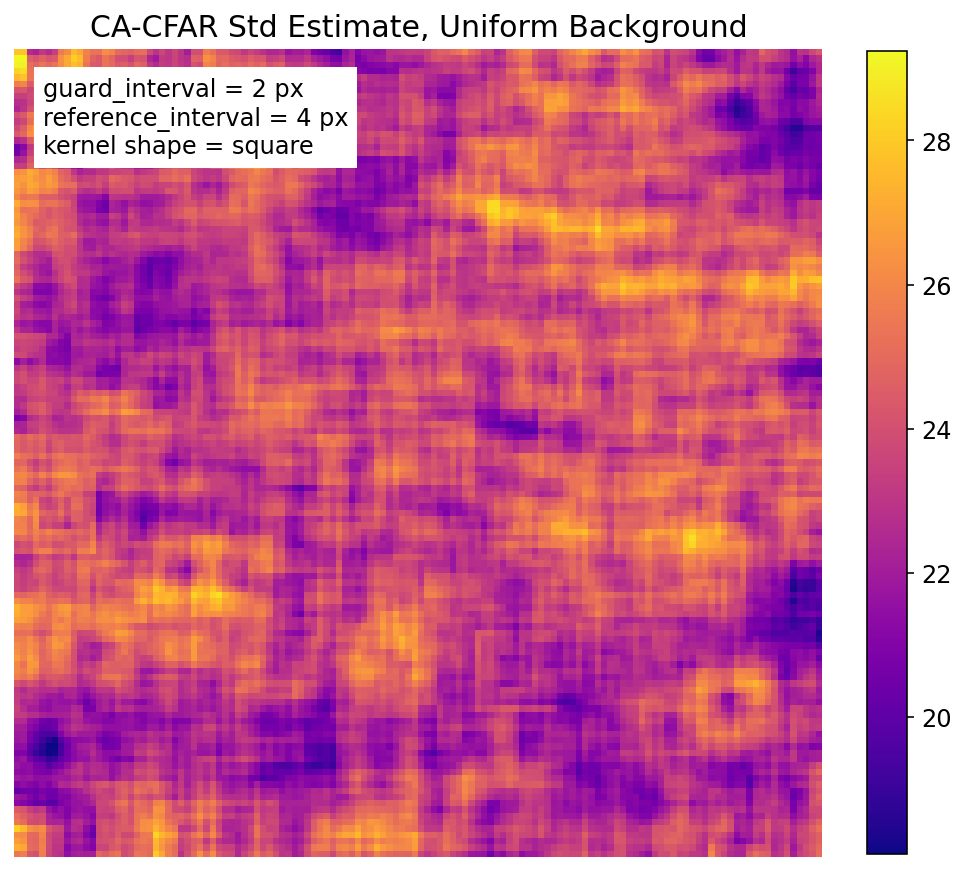

In [120]:
background_mean_estimate = cacfar_background_mean_estimate(
    T0_uniform, square_annulus_kernel, guard_interval, reference_interval)

show_image(
    cacfar_background_std_estimate(
        T0_uniform, background_mean_estimate, 
        square_annulus_kernel, guard_interval, reference_interval),
    title=f'CA-CFAR Std Estimate, Uniform Background',
    text=r'guard_interval = {} px'.format(guard_interval) +'\n'+                                     
        r'reference_interval = {} px'.format(reference_interval) +'\n'+ 
        r'kernel shape = square',
    output_file_path=output_directory/'cacfar'/'background'/
        'cacfar_uniform_background_square.png',
    )

#### CA-CFAR Non-Local Max

In [121]:
def cacfar_nonlocal_max(
    T, pfa, kernel_shape, guard_interval, reference_interval):
       
    background_mean_estimate = cacfar_background_mean_estimate(
        T, kernel_shape, guard_interval, reference_interval)
        
    background_std_estimate = cacfar_background_std_estimate(
        T, background_mean_estimate, kernel_shape, guard_interval, reference_interval)
    
    threshold = isf_threshold(pfa, background_mean_estimate, background_std_estimate)
    
    mask = T > threshold
    
    return mask

In [122]:
(output_directory/'cacfar'/'mask').mkdir(exist_ok=True)

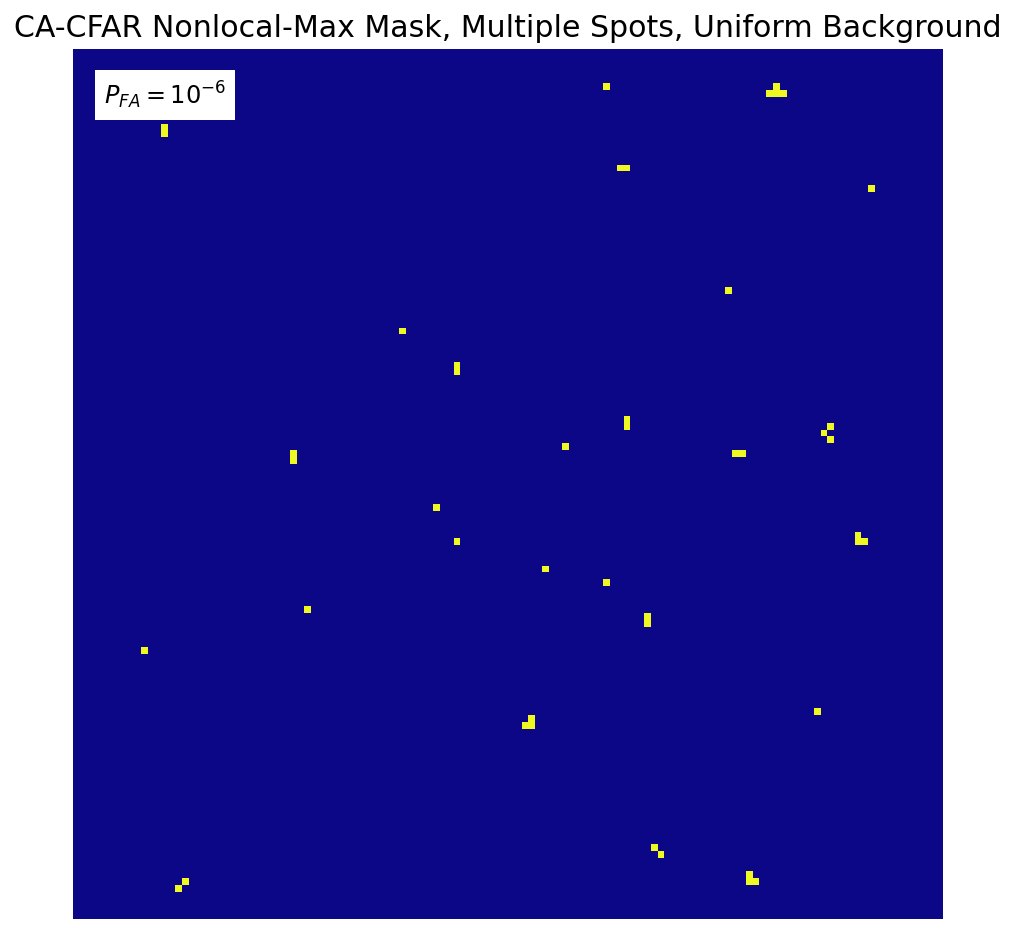

In [123]:
show_image( 
    cacfar_nonlocal_max(
        T1_uniform, pfa,
        square_annulus_kernel, guard_interval, reference_interval),
    title=f'CA-CFAR Nonlocal-Max Mask, Multiple Spots, Uniform Background',
    text=r'$P_{{FA}} = 10^{{{0}}}$'.format(log_pfa),
    show_colorbar=False,
    output_file_path=output_directory/'cacfar'/'mask'/
        f'cacfar_nonlocalmax_mask_multi_spot_uniform_background_poisson.png'
)

#### CA-CFAR

In [124]:
from ipynb.fs.defs.scalar_poisson_cfar_detector import cacfar

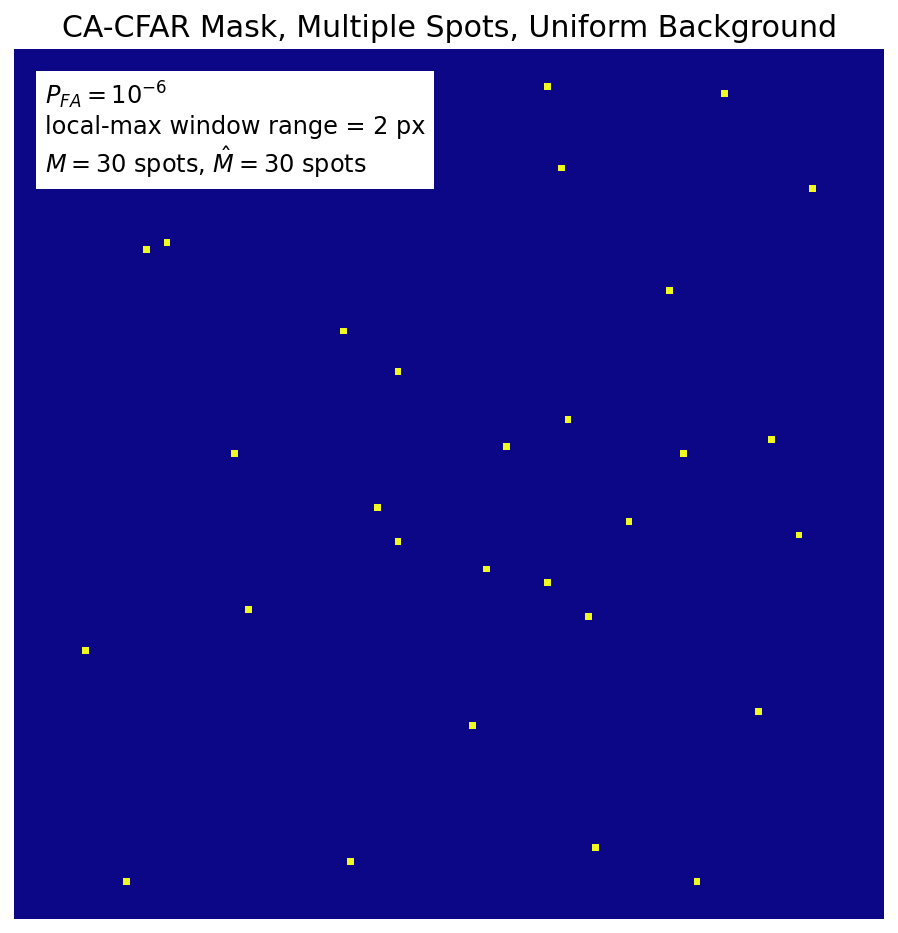

In [125]:
mask = cacfar(
    T1_uniform, pfa, local_max_range,
    square_annulus_kernel, guard_interval, reference_interval)

show_image(mask,
    title='CA-CFAR Mask, Multiple Spots, Uniform Background',
    text=r'$P_{{FA}} = 10^{{{}}}$'.format(log_pfa) +'\n'+
        r'local-max window range = {} px'.format(local_max_range) +'\n'+                                     
        r'$M={}$ spots'.format(n_spots) + 
            r', $\hat{{M}} = {}$ spots'.format(int(sum(mask))),          
    output_file_path=output_directory/'cacfar'/'mask'/
        f'cacfar_mask_multi_spot_uniform_background_poisson.png',
    show_colorbar=False
)

#### Detection Test

In [126]:
(output_directory/'cacfar'/'detection').mkdir(exist_ok=True)

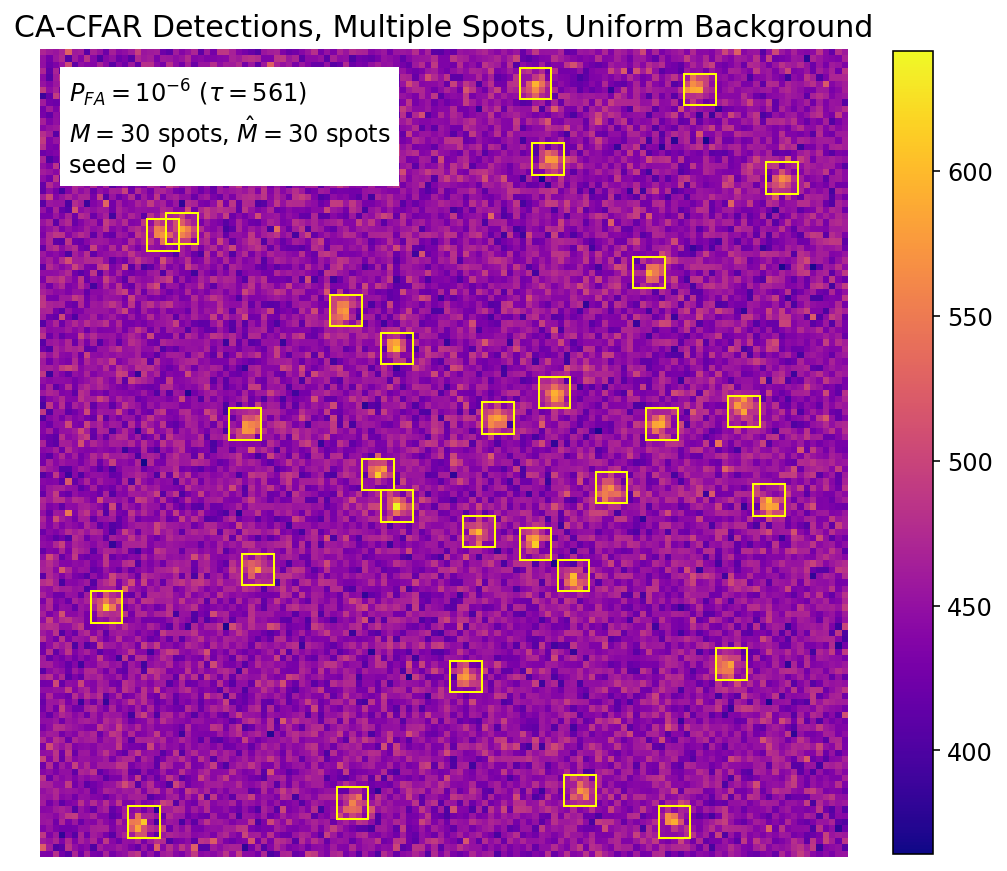

In [127]:
detection_test(
    T1_uniform, cacfar, log_pfa, 
    background_dict, signal_dict, local_max_range,
    detector_args=(square_annulus_kernel, guard_interval, reference_interval),
    title='CA-CFAR Detections, Multiple Spots, Uniform Background', seed=0)

In [128]:
for i_log_pfa in tqdm([-5,-6]):
    for i_seed in range(3):
        detection_test(
            get_multi_spot_uniform_background_poisson(
                signal_dict, integrated_gauss2d, background_dict, seed=i_seed), 
            cacfar, i_log_pfa,
            background_dict, signal_dict, local_max_range,
            detector_args=(square_annulus_kernel, guard_interval, reference_interval),
            seed=i_seed, 
            title = 'CA-CFAR Detections, Multiple Spots, Uniform Background',            
            output_file_path = output_directory/'cacfar'/'detection'/
                f'cacfar_multi_spot_uniform_background_poisson_logpfa{i_log_pfa}_seed{i_seed}.png',
            close_fig=True)

100%|██████████| 2/2 [00:22<00:00, 11.38s/it]


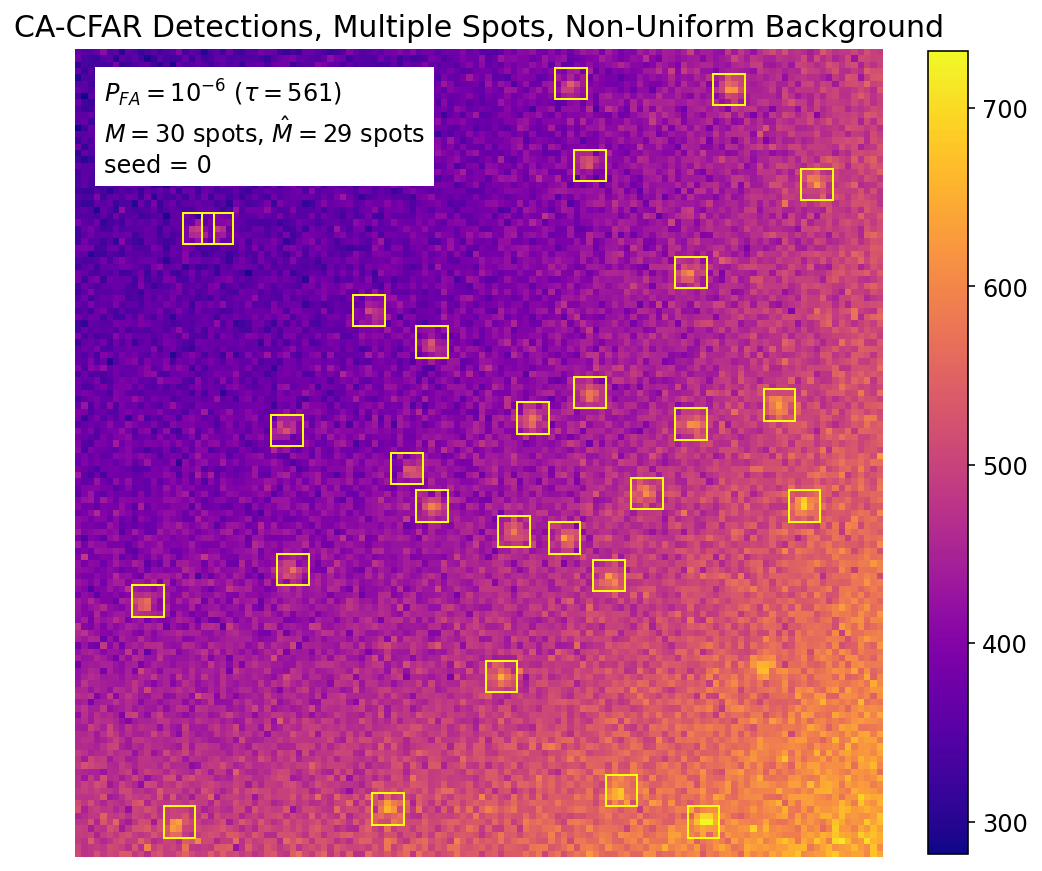

In [129]:
detection_test(
    T1_nonuniform, cacfar, log_pfa, 
    background_dict, signal_dict, local_max_range,
    detector_args=(square_annulus_kernel, guard_interval, reference_interval),
    title='CA-CFAR Detections, Multiple Spots, Non-Uniform Background', seed=0,
    output_file_path=output_directory/'cacfar'/'detection'/
        'cacfar_multi_spot_nonuniform_background_poisson.png'
)

#### False Alarm Test

In [130]:
(output_directory/'cacfar'/'false_alarm').mkdir(exist_ok=True)

In [131]:
false_alarm_test(
    T0_uniform, cacfar, -3,
    background_dict, local_max_range,  
    detector_args=(square_annulus_kernel, guard_interval, reference_interval),    
    title='CA-CFAR Detections, Uniform Background', seed=0)

In [132]:
for i_log_pfa in tqdm([-3,-4]):
    for i_seed in range(3):
        false_alarm_test(
            get_uniform_background_poisson(background_dict, seed=i_seed), 
            cacfar, i_log_pfa,  
            background_dict, local_max_range,  
            detector_args=(square_annulus_kernel, guard_interval, reference_interval),
            
            title='CA-CFAR Detections, Uniform Background',                 
            seed=i_seed,
            output_file_path = output_directory/'cacfar'/'false_alarm'/
                f'cacfar_uniform_background_poisson_logpfa{i_log_pfa}_seed{i_seed}.png',
            close_fig=True
        )

100%|██████████| 2/2 [00:03<00:00,  1.83s/it]


In [133]:
for i_log_pfa in tqdm([-3,-4]):
    for i_seed in range(3):
        false_alarm_test(
            get_nonuniform_background_poisson(background_dict, seed=i_seed),
            cacfar, i_log_pfa, 
            background_dict, local_max_range,  
            detector_args=(square_annulus_kernel, guard_interval, reference_interval),

            title='CA-CFAR Detections, Non-Uniform Background',                 
            seed=i_seed,
            output_file_path = output_directory/'cacfar'/'false_alarm'/
                f'cacfar_nonuniform_background_poisson_logpfa{i_log_pfa}_seed{i_seed}.png',
            close_fig=True
        )

100%|██████████| 2/2 [00:03<00:00,  1.88s/it]
